In [1]:
!pip install insightface
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 66.8 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055395 sha256=5695bba57bd984906e798bd5abe9442ad136c4e26481251dd2520906b16dd090
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00


In [2]:
import cv2
from insightface.app import FaceAnalysis
import torch

app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

image = cv2.imread("./IMG20230128132730.jpg")
faces = app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 86080.02KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [3]:
!pip install huggingface_hub
!pip install ip_adapter

In [4]:
from huggingface_hub import hf_hub_download

ip_adapter_ckpt_path = "/content/ip-adapter-faceid_sd15.bin"

hf_hub_download(
    repo_id="h94/IP-Adapter-FaceID",
    filename="ip-adapter-faceid_sd15.bin",
    local_dir="/content",
    use_auth_token=False
    )

print("Downloaded IP-Adapter checkpoint saved to:", ip_adapter_ckpt_path)


ip-adapter-faceid_sd15.bin:   0%|          | 0.00/96.7M [00:00<?, ?B/s]

Downloaded IP-Adapter checkpoint saved to: /content/ip-adapter-faceid_sd15.bin


In [16]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter.ip_adapter_faceid import IPAdapterFaceID

# Model and configuration paths
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
ip_ckpt = "ip-adapter-faceid_sd15.bin"
device = "cuda"

# Define the noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

# Load the VAE
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# Initialize the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

# Load the IP adapter for face conditioning
ip_model = IPAdapterFaceID(pipe, ip_ckpt, device)



Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/lora.py:208: FutureWarning: `LoRALinearLayer` is deprecated and will be removed in version 1.0.0. Use of `LoRALinearLayer` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRALinearLayer", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/ip_adapter/ip_adapter_faceid.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

In [17]:
torch.cuda.empty_cache()

  0%|          | 0/30 [00:00<?, ?it/s]

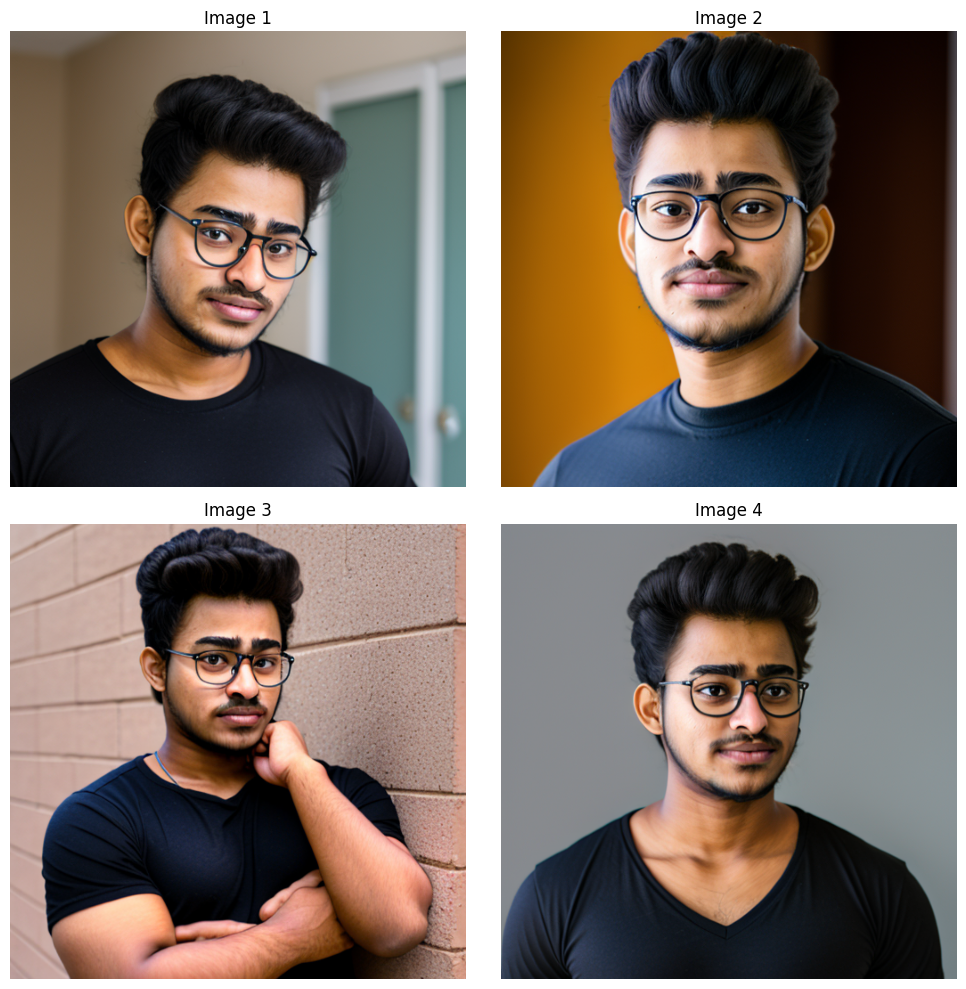

In [23]:
# Define the prompt and negative prompt
prompt = "photo of a man in black shirt"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry"

# Ensure faceid_embeds is defined before calling generate
try:
    images = ip_model.generate(
        prompt=prompt,
        negative_prompt=negative_prompt,
        faceid_embeds=faceid_embeds,  # Ensure this variable is properly initialized
        num_samples=4,
        width=512,
        height=512,
        num_inference_steps=30,
        seed=2023
    )

    # Create a directory to save the images
    os.makedirs("generated", exist_ok=True)

    # Save images and prepare for display
    for i, img in enumerate(images):
        img_path = f"generated/generated_image_{i}.png"
        img.save(img_path)

    # Display the images in a 2x2 grid
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis
        plt.title(f"Image {i + 1}")

    plt.tight_layout()
    plt.show()

except NameError:
    print("Error: faceid_embeds is not defined. Please ensure it is initialized before generating images.")
